# ABC calibration of $I_\text{Kur}$ in standardised model to unified dataset.

Note the term $I_\text{sus}$ for sustained outward Potassium current is used throughout the notebook.

In [1]:
import os, tempfile
import logging
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
from ionchannelABC import theoretical_population_size
from ionchannelABC import IonChannelDistance, EfficientMultivariateNormalTransition, IonChannelAcceptor
from ionchannelABC.experiment import setup
from ionchannelABC.visualization import plot_sim_results, plot_kde_matrix_custom
import myokit

INFO:myokit:Loading Myokit version 1.28.3


In [3]:
from pyabc import Distribution, RV, History, ABCSMC
from pyabc.epsilon import MedianEpsilon
from pyabc.sampler import MulticoreEvalParallelSampler, SingleCoreSampler
from pyabc.populationstrategy import ConstantPopulationSize

## Initial set-up

Load experiments used for unified dataset calibration:
 - Steady-state activation [Wang1993]
 - Activation time constant [Wang1993]
 - Deactivation time constant [Courtemanche1998]
 - Steady-state inactivation [Firek1995]
 - Inactivation time constant [Nygren1998]
 - Recovery time constant [Nygren1998]

In [4]:
from experiments.isus_wang import wang_act_and_kin
from experiments.isus_courtemanche import courtemanche_deact
from experiments.isus_firek import (firek_inact)
from experiments.isus_nygren import (nygren_inact_kin,
                                     nygren_rec)

In [5]:
modelfile = 'models/standardised_isus.mmt'

Plot steady-state and tau functions

In [7]:
from ionchannelABC.visualization import plot_variables

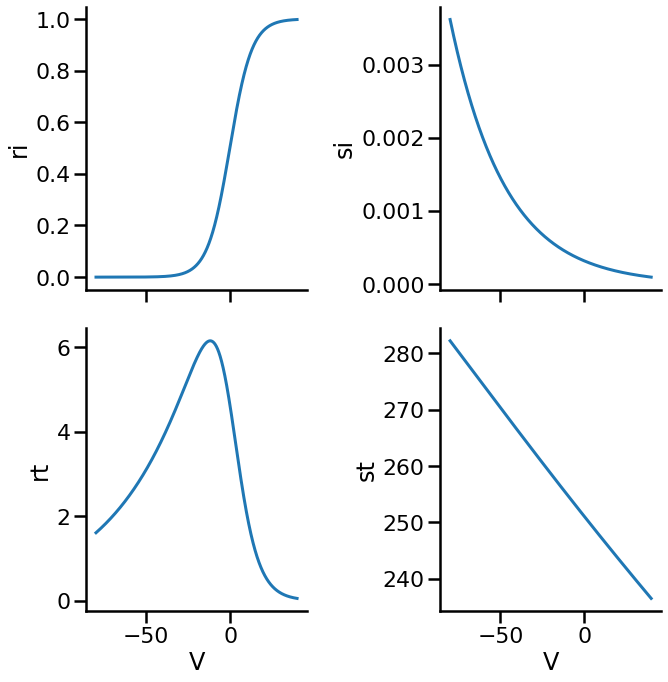

In [8]:
sns.set_context('poster')

V = np.arange(-80, 40, 0.01)

sta_par_map = {'ri': 'isus.r_ss',
            'si': 'isus.s_ss',
            'rt': 'isus.tau_r',
            'st': 'isus.tau_s'}

f, ax = plot_variables(V, sta_par_map, modelfile, figshape=(2,2))

Combine model and experiments to produce:
 - observations dataframe
 - model function to run experiments and return traces
 - summary statistics function to accept traces

In [9]:
observations, model, summary_statistics = setup(modelfile,
                                                wang_act_and_kin,
                                                courtemanche_deact,
                                                firek_inact,
                                                nygren_inact_kin,
                                                nygren_rec)

In [10]:
assert len(observations)==len(summary_statistics(model({})))

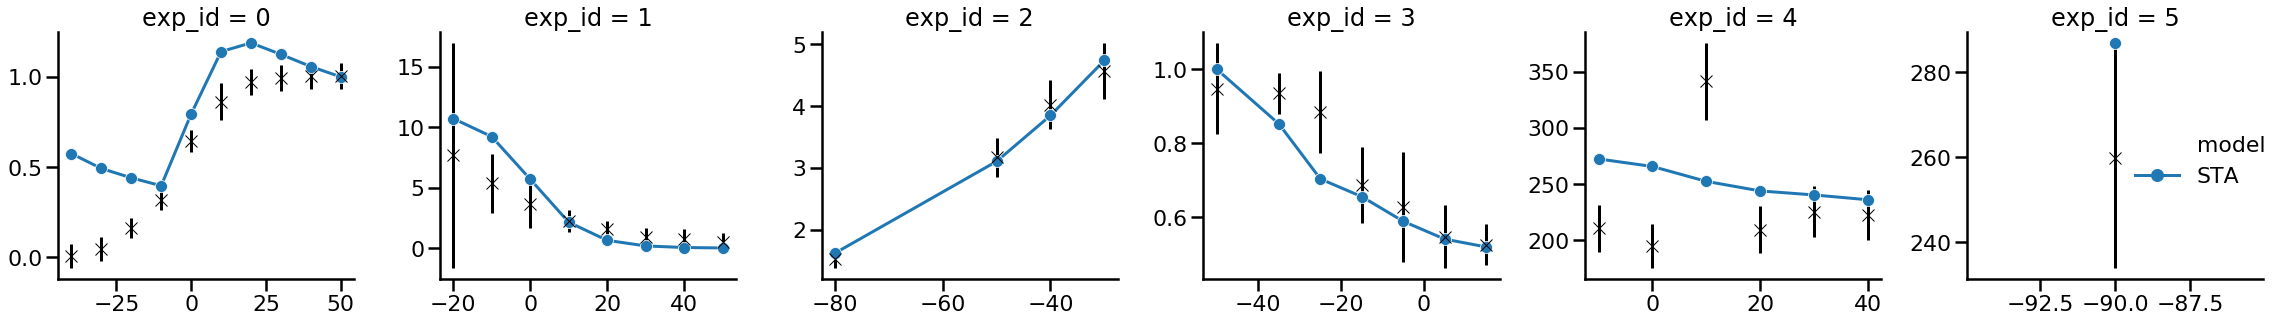

In [11]:
g = plot_sim_results(modelfile,
                     wang_act_and_kin,
                     courtemanche_deact,
                     firek_inact,
                     nygren_inact_kin,
                     nygren_rec)

### Set up prior ranges for each parameter in the model.

See the modelfile for further information on specific parameters. Prepending `log_' has the effect of setting the parameter in log space.

In [12]:
limits = {'log_isus.p_1': (-7, 3),
          'isus.p_2': (1e-7, 0.4),
          'log_isus.p_3': (-7, 3),
          'isus.p_4': (1e-7, 0.4),
          'log_isus.p_5': (-7, 3),
          'isus.p_6': (1e-7, 0.4),
          'log_isus.p_7': (-7, 3),
          'isus.p_8': (1e-7, 0.4)}
prior = Distribution(**{key: RV("uniform", a, b - a)
                        for key, (a,b) in limits.items()})

In [13]:
# Test this works correctly with set-up functions
assert len(observations) == len(summary_statistics(model(prior.rvs())))

### Run ABC calibration

In [16]:
db_path = ("sqlite:///" + os.path.join(tempfile.gettempdir(), "standardised_isus.db"))

In [17]:
logging.basicConfig()
abc_logger = logging.getLogger('ABC')
abc_logger.setLevel(logging.DEBUG)
eps_logger = logging.getLogger('Epsilon')
eps_logger.setLevel(logging.DEBUG)

In [18]:
pop_size = theoretical_population_size(2, len(limits))
print("Theoretical minimum population size is {} particles".format(pop_size))

Theoretical minimum population size is 256 particles


In [19]:
abc = ABCSMC(models=model,
             parameter_priors=prior,
             distance_function=IonChannelDistance(
                 exp_id=list(observations.exp_id),
                 variance=list(observations.variance),
                 delta=0.05),
             population_size=ConstantPopulationSize(1000),
             summary_statistics=summary_statistics,
             transitions=EfficientMultivariateNormalTransition(),
             eps=MedianEpsilon(initial_epsilon=100),
             sampler=MulticoreEvalParallelSampler(n_procs=16),
             acceptor=IonChannelAcceptor())

DEBUG:ABC:ion channel weights: {'0': 0.757484747137524, '1': 0.7573300005088944, '2': 0.9251635519069269, '3': 0.9253944963781887, '4': 0.8326887584211609, '5': 0.490037059152811, '6': 0.6942191671331489, '7': 0.6943491950723016, '8': 0.6943491950723043, '9': 0.6942191671331489, '10': 0.0514522386566513, '11': 0.19684348434442256, '12': 0.23830510535712207, '13': 0.5326820002100388, '14': 0.6970165465194014, '15': 0.6035440238875321, '16': 0.5326820002100352, '17': 0.6464557607615167, '18': 2.5006823491663805, '19': 1.800766811632805, '20': 1.4186759812504586, '21': 1.2503411745831903, '22': 0.5481676012334781, '23': 1.2228354181362266, '24': 0.6114177090681118, '25': 0.6623691848237867, '26': 0.454196012450596, '27': 0.7948430217885437, '28': 1.2228354181362204, '29': 1.3506232161700145, '30': 1.4613353773463804, '31': 0.83356078305546, '32': 1.3602421373437368, '33': 1.2631702345856923, '34': 1.2783563730330265, '35': 5.001364698332761}
DEBUG:Epsilon:init quantile_epsilon initial_eps

In [20]:
obs = observations.to_dict()['y']
obs = {str(k): v for k, v in obs.items()}

In [21]:
abc_id = abc.new(db_path, obs)

INFO:History:Start <ABCSMC(id=4, start_time=2019-10-30 09:51:20.693959, end_time=None)>


In [ ]:
history = abc.run(minimum_epsilon=0., max_nr_populations=100, min_acceptance_rate=0.01)

INFO:ABC:t:0 eps:100
DEBUG:ABC:now submitting population 0


In [ ]:
history = abc.run(minimum_epsilon=0., max_nr_populations=100, min_acceptance_rate=0.01)

### Analysis of results

In [14]:
history = History('sqlite:///results/standardised/isus/standardised_isus.db')

In [15]:
df, w = history.get_distribution(m=0)

In [16]:
df.describe()

name,isus.p_2,isus.p_4,isus.p_6,isus.p_8,log_isus.p_1,log_isus.p_3,log_isus.p_5,log_isus.p_7
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.148526,0.020202,0.001559,0.027597,-1.261242,-0.924747,-2.352085,-6.820690
std,0.012002,0.000898,0.000183,0.002007,0.051327,0.019491,0.006502,0.160979
min,0.120513,0.017286,0.000954,0.021316,-1.381498,-0.991677,-2.370927,-6.999985
25%,0.139339,0.019553,0.001431,0.026243,-1.300054,-0.938004,-2.356456,-6.934211
50%,0.147152,0.020160,0.001566,0.027664,-1.258827,-0.924096,-2.351961,-6.860678
75%,0.156713,0.020825,0.001678,0.028971,-1.220041,-0.910935,-2.347869,-6.756314
max,0.192503,0.023309,0.002087,0.034171,-1.122041,-0.860656,-2.330519,-5.943701


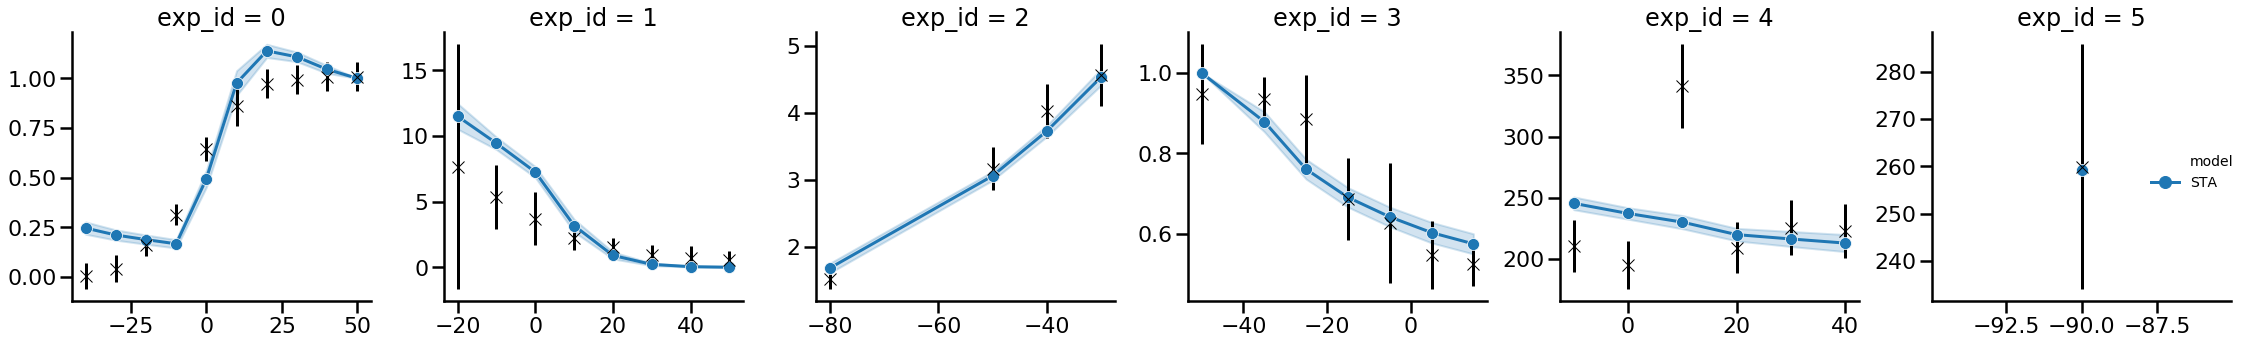

In [17]:
sns.set_context('poster')

mpl.rcParams['font.size'] = 14
mpl.rcParams['legend.fontsize'] = 14


g = plot_sim_results(modelfile,
                     wang_act_and_kin,
                     courtemanche_deact,
                     firek_inact,
                     nygren_inact_kin,
                     nygren_rec,
                     df=df, w=w)

plt.tight_layout()

In [18]:
import pandas as pd
N = 100
sta_par_samples = df.sample(n=N, weights=w, replace=True)
sta_par_samples = sta_par_samples.set_index([pd.Index(range(N))])
sta_par_samples = sta_par_samples.to_dict(orient='records')

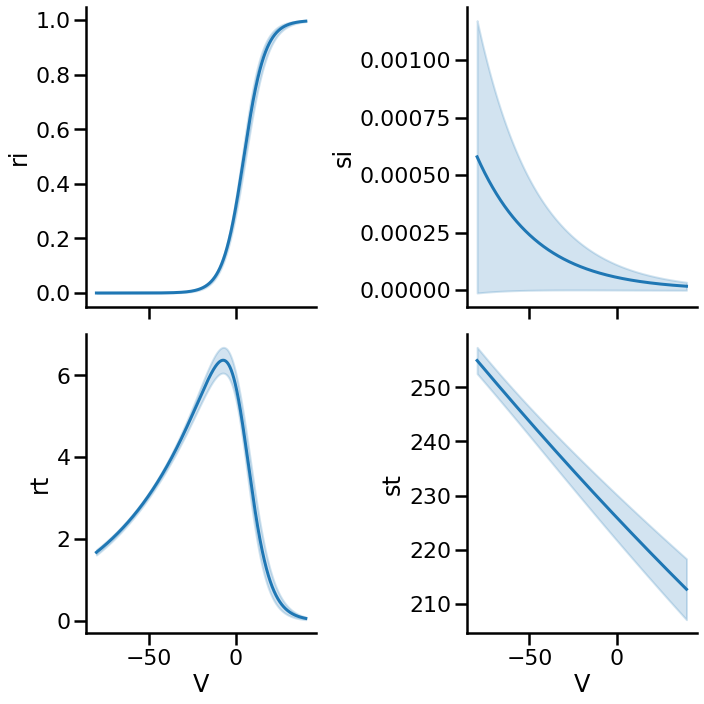

In [19]:
sns.set_context('poster')
mpl.rcParams['font.size'] = 14
mpl.rcParams['legend.fontsize'] = 14

f, ax = plot_variables(V, sta_par_map, 
                       modelfile, 
                       [sta_par_samples],
                       figshape=(2,2))
plt.tight_layout()

In [20]:
m,_,_ = myokit.load(modelfile)

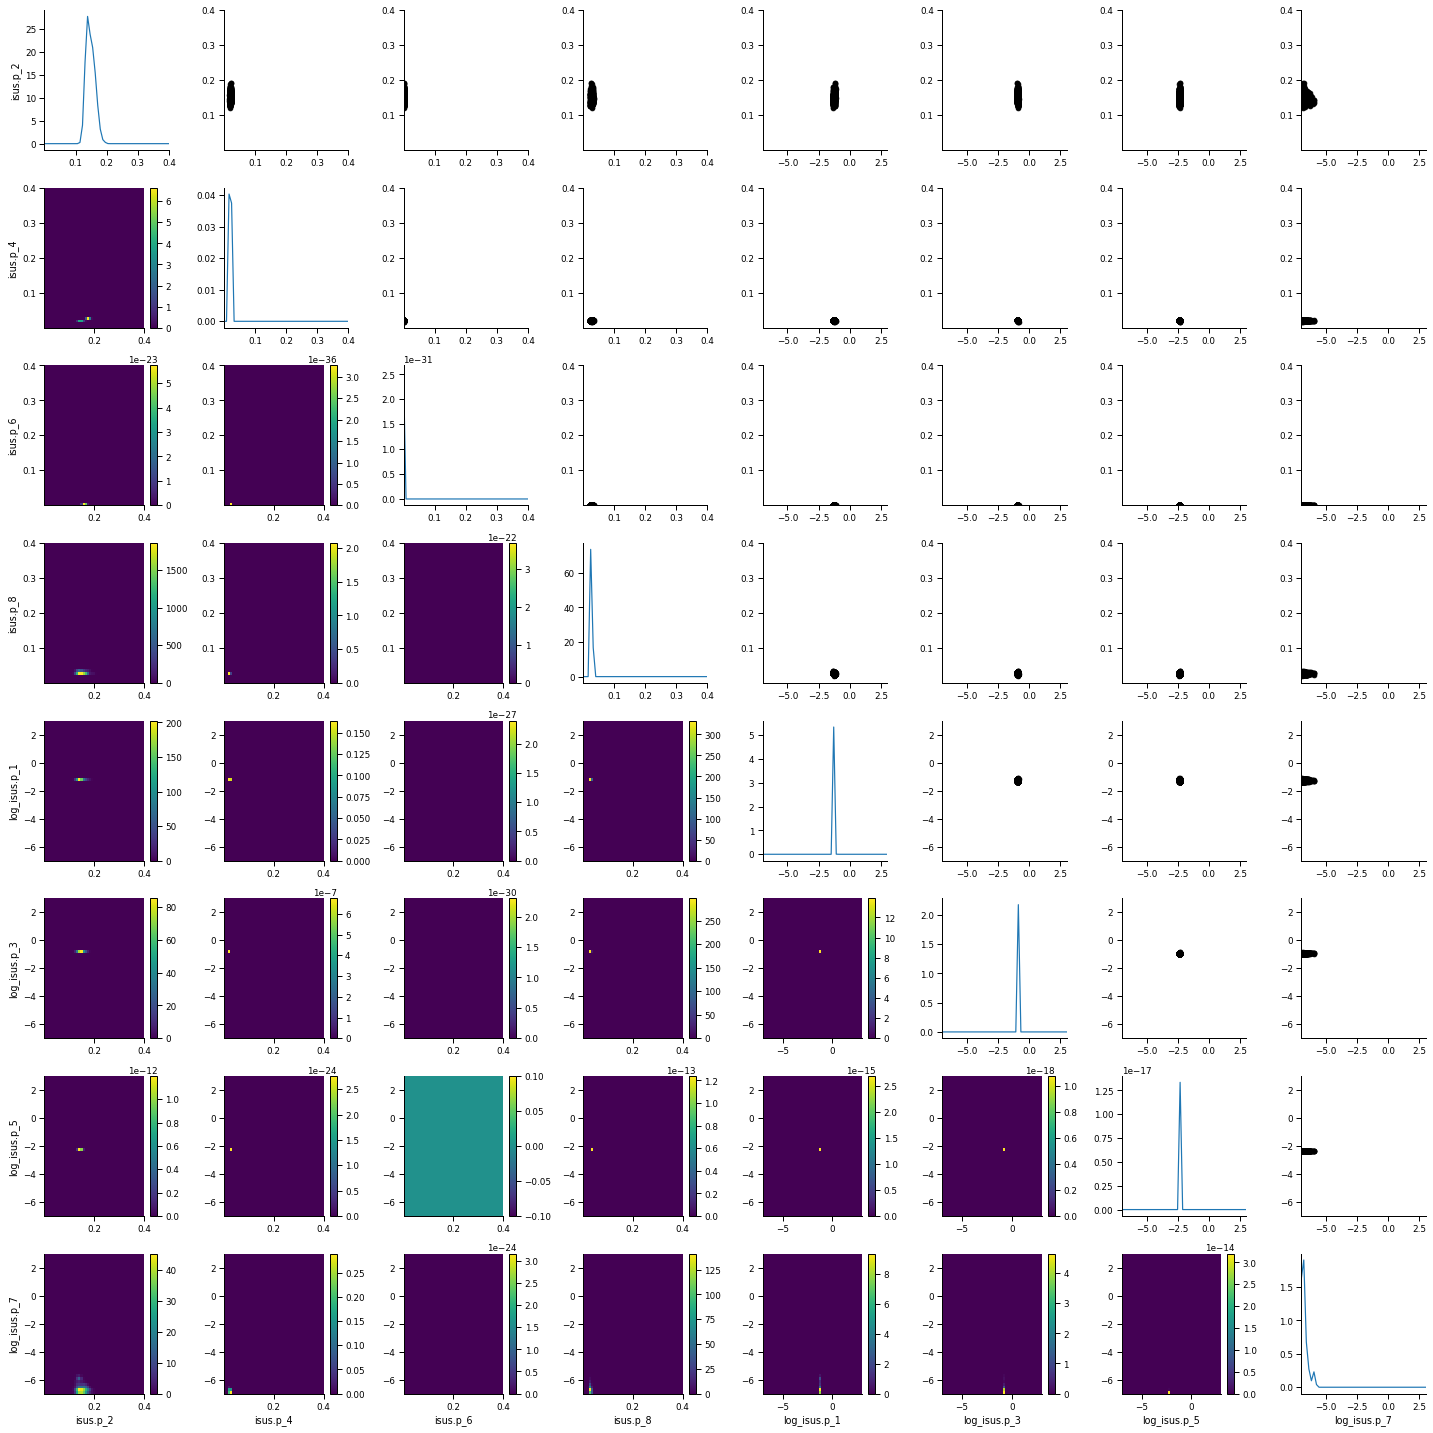

In [21]:
sns.set_context('paper')
g = plot_kde_matrix_custom(df, w, limits=limits)
plt.tight_layout()